In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import math
from datetime import timedelta

import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, confusion_matrix

In [2]:
tf.Variable(True)

Instructions for updating:
Colocations handled automatically by placer.


<tf.Variable 'Variable:0' shape=() dtype=bool_ref>

## Flowers

https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

In [3]:
import wget

dataurl = 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
basedir = './data/'

if not os.path.exists(basedir + 'flower_data.tar.gz'):
    wget.download(dataurl, basedir)

In [4]:
class imagefolder:
    def __init__(self, basedir, imgshape, nchannels):
        self.basedir = basedir
        self.nchannels = nchannels
        self.imgshape = imgshape
        self.classdict = {}
        
        self.pathdict = {}
        self.labeldict = {}
        
        self.tfdict = {}
        self.npdict = {}
        
        self._nparray = np.zeros((1,1) )
        self._nplist = list()
    
    def loadpaths(self, subdir = '.', classes = 'all'):
        imagepaths, labels = list(), list()
        datadir = self.basedir + '/' + subdir
        _, classlist, imagelist = os.walk(datadir).__next__()
        
        if len(classlist) > 0 and classes is not 'all':
            classlist = classes
            
        label = 0
        for c in classlist:
            c_dir = os.path.join(datadir, c)
            filelist = os.walk(c_dir).__next__()[2]
            
            for sample in filelist:
                if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                    imagepaths.append(os.path.join(c_dir, sample))
                    labels.append(label)
            if c not in self.classdict:
                self.classdict[label] = c
            label += 1
        
        setname = subdir if subdir is not '.' else 'all'
        self.pathdict[setname] = imagepaths
        
        if label > 0:
            self.labeldict[setname] = labels
            
    def onehot(self, classes):
        nclasses = len(self.classdict)
        return np.eye(nclasses, dtype=float)[classes]
        
    def _tfparse(self, filename, label):
        imgstr = tf.read_file(filename)
        imgdec = tf.image.decode_jpeg(imgstr, channels = self.nchannels)
        imgresize = tf.image.resize_images(imgdec, [self.imgshape[0], self.imgshape[1]])
        return imgresize, label

    def tfloaddata(self, batchsize = 1, shuffle = True):
        assert len(self.pathdict) > 0
        
        for xtype in self.pathdict:
            paths = self.pathdict[xtype]
            labels = self.labeldict[xtype]
            data = tf.data.Dataset.from_tensor_slices((paths, labels))
            data = data.map(self._tfparse)
            data = data.shuffle(buffer_size = len(paths)) if shuffle is True else data
            self.tfdict[xtype] = data.batch(batchsize)
    
    def _npresize(self, filename):
        img = cv2.imread(filename )
        rimg = cv2.resize(img, (self.imgshape[0], self.imgshape[1]) )

        idx = self._nplist.index(filename)
        self._nparray[idx] = rimg
    
    def npload(self):
        assert len(self.pathdict) > 0
        
        from multiprocessing import pool
        from multiprocessing.dummy import Pool as DumbPool
        
        for xtype in self.pathdict:
            paths = self.pathdict[xtype]
            labels = self.labeldict[xtype]
            
            self._nplist = paths
            self._nparray = np.zeros((len(self._nplist), self.imgshape[0], \
                                      self.imgshape[1], self.nchannels))
            pool = DumbPool(4)
            pool.map(self._npresize, self._nplist )
            
            self.npdict[xtype] = self._nparray
            
    def npgetbatch(self, xtype, batchsize = 1, onehot = True):
        assert xtype in self.npdict
        #np.random.seed(42)
        
        if isinstance(batchsize, int):
            idx = np.random.randint(low=0, high=len(self.npdict[xtype]), size=batchsize)
        else:
            assert batchsize is 'all'
            idx = np.array(range(len(self.npdict[xtype])))
            
        x_batch = self.npdict[xtype][idx]
        
        if onehot:
            y_batch = self.onehot(np.array(self.labeldict[xtype])[idx])
        else:
            y_batch = np.array(self.labeldict[xtype])[idx]

        return x_batch, y_batch

In [5]:
def plot_image(image):
    # Create figure with 3x3 sub-plots.
    fig, ax = plt.subplots(1, 1)
    
    if image.shape[2] == 1:
        image = image[:, :, 0]
    ax.imshow(image.astype(int), cmap = 'gray')
    plt.show()

In [6]:
subclasses = ['1', '10', '20']

imgloader = imagefolder(basedir, [120, 120], 3)
imgloader.loadpaths('train', classes = subclasses)
imgloader.loadpaths('test', classes = subclasses)

## NumPy based network

In [7]:
imgloader.npload()
len(imgloader.npdict['train'])
len(imgloader.npdict['test'])

111

11

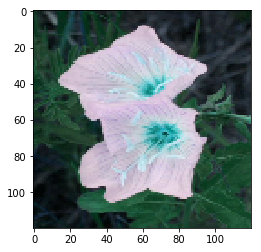

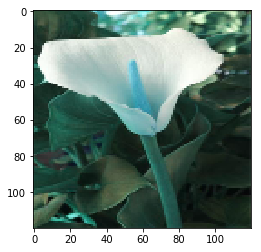

In [8]:
npbatchtrain = imgloader.npgetbatch('train', batchsize = 1)[0]
npbatchtest = imgloader.npgetbatch('test', batchsize = 1)[0]
plot_image(npbatchtrain[0])
plot_image(npbatchtest[0])

In [70]:
class Network:
    def __init__(self, inputshape, nchannels, nclasses):
        self.nchannels = nchannels
        self.nclasses = nclasses
        self.states, self.shapes = {}, {}
        self.weights, self.biases = {}, {}
        self.finalresults = {}
        
        self.ilayer = 0
        inputsize = np.prod(inputshape + [nchannels])
        
        self.droprate = tf.placeholder(tf.float32)
        self.x = tf.placeholder(tf.float32, shape=[None, inputsize], name='x')
        self.y = tf.placeholder(tf.float32, shape=[None, self.nclasses], name='y')
        self.yclass = tf.argmax(self.y, axis=1)
        
        self.weights['0_Init'] = None
        self.biases['0_Init'] = None
        self.shapes['0_Init'] = inputshape + [nchannels]
        self.states['0_Init'] = self.x
        
    def _initweights(self, shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.05, dtype=tf.float32))
#         return tf.Variable(tf.truncated_normal(shape, stddev=0.05, dtype=tf.float32, seed = 1234))

    def _initbias(self, length):
        return tf.Variable(tf.constant(0.05, shape=[length]))
    
    def initconv2d(self):
        batchshape = [-1] + self.shapes['0_Init'][:-1] + [self.nchannels]
        self.states['0_Init'] = tf.reshape(self.states['0_Init'], batchshape)
        
    def activate(self, activation = 'relu'):
        prename = list(self.states.keys())[-1]
        assert activation in ['relu', 'sigmoid']
        
        if activation is 'relu':
            self.states[prename] = tf.nn.relu(self.states[prename])
        elif activation is 'sigmoid':
            self.states[prename] = tf.nn.sigmoid(self.states[prename])
        
    def dropout(self):
        prename = list(self.states.keys())[-1]
        assert len(self.shapes[prename]) == 1
        
        self.states[prename] = tf.nn.dropout(self.states[prename], rate = self.droprate)

    def pool(self, poolsize):
        prename = list(self.states.keys())[-1]
        assert len(self.shapes[prename]) == 3
        assert len(poolsize) == 2
        
        self.ilayer += 1
        name = str(self.ilayer) + '_Pool'
        
        ksize = [1] + poolsize + [1]
        strides = [1] + poolsize + [1]
        self.states[name] = tf.nn.max_pool(self.states[prename], ksize=ksize, \
                                           strides=strides, padding='SAME')
        self.weights[name] = None
        self.biases[name] = None
        self.shapes[name] = self.states[name].get_shape()[1:].as_list()
        
    def flatten(self):
        prename = list(self.states.keys())[-1]
        assert len(self.shapes[prename]) == 3
        
        self.ilayer += 1
        name = str(self.ilayer) + '_Flat'
        self.shapes[name] = [np.prod(self.states[prename].get_shape()[1:].as_list())]
        self.states[name] = tf.reshape(self.states[prename], [-1, self.shapes[name][0]])
        self.weights[name] = None
        self.biases[name] = None
        
    def addconv2d(self, inchannels, outchannels, kernel, stride):
        prename = list(self.states.keys())[-1]
        self.ilayer += 1
        name = str(self.ilayer) + '_Conv2D'
        
        shape = [kernel, kernel, inchannels, outchannels]
        weights = self._initweights(shape = shape)
        biases = self._initbias(length = outchannels)
        strides = [1] + [stride, stride] + [1]

        self.states[name] = tf.nn.conv2d(self.states[prename], weights, \
                                         strides=strides, padding='SAME') + biases  
        self.shapes[name] = self.states[name].get_shape()[1:].as_list()
        self.weights[name] = weights
        self.biases[name] = biases
    
    def addlinear(self, outputsize):
        prename = list(self.states.keys())[-1]
        assert len(self.shapes[prename]) == 1
        
        self.ilayer += 1
        name = str(self.ilayer) + '_Linear'
        
        shape = [np.prod(self.shapes[prename]), outputsize]
        weights = self._initweights(shape=shape)
        biases = self._initbias(length=outputsize)
        
        self.states[name] = tf.matmul(self.states[prename], weights) + biases
        self.shapes[name] = self.states[name].get_shape()[1:].as_list()
        self.weights[name] = weights
        self.biases[name] = biases
        
    def addfinal(self):
        prename = list(self.states.keys())[-1]
        
        self.ilayer += 1
        name = 'Final'
        
        shape = [np.prod(self.shapes[prename]), self.nclasses]
        weights = self._initweights(shape=shape)
        biases = self._initbias(length=self.nclasses)
        
        self.states[name] = tf.add(tf.matmul(self.states[prename], weights), \
                                   biases, name='final')
        self.shapes[name] = self.states[name].get_shape()[1:].as_list()
        self.weights[name] = weights
        self.biases[name] = biases
        
    def confusionmatrix(self):
        assert len(self.finalresults) == 2
        
        cm = confusion_matrix(self.finalresults['truth'], self.finalresults['predictions'])
        plt.matshow(cm)
        plt.colorbar()
        tick_marks = np.arange(self.nclasses)
        plt.xticks(tick_marks, range(self.nclasses))
        plt.yticks(tick_marks, range(self.nclasses))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
    def train(self, dataloader, batchsize, learnrate, nepochs, printevery = 10):
        prename = list(self.states.keys())[-1]
        pretag = self.states[prename].name.split('_')[0]
        assert prename is 'Final'
        assert pretag not in ['Relu']
        
        ypred = tf.nn.softmax(self.states[prename])
        ypredclass = tf.argmax(ypred, axis=1)

        correct = tf.equal(self.yclass, ypredclass)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.states[prename], \
                                                           labels=self.y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer(learning_rate=learnrate).minimize(loss)
        
        global epoch
        epoch = 0
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            start_time = time.time()
            
            trainloss, trainacc, nbatches = 0, 0, 0

            for i in range(epoch, epoch + nepochs):
                x_train, y_train = dataloader.npgetbatch('train', batchsize = batchsize)
                x_train = x_train.reshape(-1, np.prod(self.shapes['0_Init']))
                feed_dict_train = {self.x: x_train, self.y: y_train, self.droprate: 0.25}
                
                _, batchloss, batchacc = sess.run([optimizer, loss, accuracy], feed_dict=feed_dict_train)
                trainloss += batchloss
                trainacc += batchacc
                nbatches += 1
                
                if i%printevery == 0:
                    # Calculate training averages
                    avgloss = trainloss/nbatches
                    avgacc = trainacc/nbatches
                    trainloss, trainacc, nbatches = 0, 0, 0
                    
                    # Calculate test accuracy
                    x_test, y_test = dataloader.npgetbatch('test', batchsize = 'all')
                    x_test = x_test.reshape(-1, np.prod(self.shapes['0_Init']))
                    feed_dict_test = {self.x: x_test, self.y: y_test, self.droprate: 0.0}
                    
                    testacc, testloss = sess.run([accuracy, loss], feed_dict=feed_dict_test)

                    msg = "Epoch: {0:>1}, Train Loss: {1:.2f}, Train Acc: {2:>6.1%} {3:>3}"
                    testmsg = "Test Loss: {0:.2f}, Test Acc: {1:>6.1%}"
                    print(msg.format(i + 1, avgloss, avgacc, '') + testmsg.format(testloss, testacc))

            epoch += nepochs

            end_time = time.time()
            time_dif = end_time - start_time
            
            print("\n###### Training complete ######")
            print("###### Time usage: " + str(timedelta(seconds=int(round(time_dif)))) + "\n")
            
            x_test, y_test = dataloader.npgetbatch('test', batchsize = 'all')
            x_test = x_test.reshape(-1, np.prod(self.shapes['0_Init']))
            feed_dict_test = {self.x: x_test, self.y: y_test, self.droprate: 0.0}
                    
            final_acc, final_ypred = sess.run([accuracy, ypredclass], feed_dict=feed_dict_test)
            final_ytrue = np.argmax(y_test, 1)
            
            self.finalresults['truth'] = final_ytrue
            self.finalresults['predictions'] = final_ypred
            
            print("Accuracy:", np.around(final_acc, 3) )
            print("Precision:", np.around(precision_score(final_ytrue, final_ypred, average='micro'), 3) )
            print("Recall:", np.around(recall_score(final_ytrue, final_ypred, average='micro'), 3) )
            print("F1:", np.around(f1_score(final_ytrue, final_ypred, average='micro'), 3) )
            #print("Confusion Matrix:" )
            #print(confusion_matrix(final_ytrue, final_ypred) )
            #fpr, tpr, thresholds = roc_curve(final_ytrue, final_ypred)

In [71]:
testnet = Network(imgloader.imgshape, imgloader.nchannels, len(imgloader.classdict))
testnet.initconv2d()

testnet.addconv2d(3, 16, 4, 1)
testnet.pool(poolsize = [2, 2])
testnet.activate(activation = 'relu')

testnet.addconv2d(16, 32, 4, 1)
testnet.activate(activation = 'relu')
testnet.pool(poolsize = [2, 2])

testnet.addconv2d(32, 64, 4, 1)
testnet.activate(activation = 'relu')
testnet.pool(poolsize = [2, 2])

testnet.flatten()
testnet.addlinear(50)
testnet.activate(activation = 'relu')
testnet.dropout()
testnet.addlinear(50)
testnet.activate(activation = 'relu')
testnet.dropout()
testnet.addfinal()

testnet.states

{'0_Init': <tf.Tensor 'Reshape_36:0' shape=(?, 120, 120, 3) dtype=float32>,
 '1_Conv2D': <tf.Tensor 'add_62:0' shape=(?, 120, 120, 16) dtype=float32>,
 '2_Pool': <tf.Tensor 'Relu_62:0' shape=(?, 60, 60, 16) dtype=float32>,
 '3_Conv2D': <tf.Tensor 'Relu_63:0' shape=(?, 60, 60, 32) dtype=float32>,
 '4_Pool': <tf.Tensor 'MaxPool_13:0' shape=(?, 30, 30, 32) dtype=float32>,
 '5_Conv2D': <tf.Tensor 'Relu_64:0' shape=(?, 30, 30, 64) dtype=float32>,
 '6_Pool': <tf.Tensor 'MaxPool_14:0' shape=(?, 15, 15, 64) dtype=float32>,
 '7_Flat': <tf.Tensor 'Reshape_37:0' shape=(?, 14400) dtype=float32>,
 '8_Linear': <tf.Tensor 'dropout_36/mul:0' shape=(?, 50) dtype=float32>,
 '9_Linear': <tf.Tensor 'dropout_37/mul:0' shape=(?, 50) dtype=float32>,
 'Final': <tf.Tensor 'final_18:0' shape=(?, 3) dtype=float32>}

In [72]:
testnet.train(imgloader, batchsize = 25, learnrate = 0.0001, nepochs=100, printevery = 10)

Epoch: 1, Train Loss: 1.29, Train Acc:  56.0%    Test Loss: 1.56, Test Acc:  27.3%
Epoch: 11, Train Loss: 1.13, Train Acc:  47.6%    Test Loss: 1.21, Test Acc:  27.3%
Epoch: 21, Train Loss: 0.90, Train Acc:  58.4%    Test Loss: 1.16, Test Acc:  27.3%
Epoch: 31, Train Loss: 0.81, Train Acc:  64.0%    Test Loss: 1.03, Test Acc:  36.4%
Epoch: 41, Train Loss: 0.65, Train Acc:  73.6%    Test Loss: 1.00, Test Acc:  54.5%
Epoch: 51, Train Loss: 0.57, Train Acc:  75.6%    Test Loss: 0.88, Test Acc:  54.5%
Epoch: 61, Train Loss: 0.50, Train Acc:  83.2%    Test Loss: 0.71, Test Acc:  81.8%
Epoch: 71, Train Loss: 0.36, Train Acc:  86.4%    Test Loss: 0.88, Test Acc:  54.5%
Epoch: 81, Train Loss: 0.32, Train Acc:  88.0%    Test Loss: 0.59, Test Acc:  81.8%
Epoch: 91, Train Loss: 0.28, Train Acc:  91.6%    Test Loss: 0.83, Test Acc:  72.7%

###### Training complete ######
###### Time usage: 0:00:56

Accuracy: 0.818
Precision: 0.818
Recall: 0.818
F1: 0.818


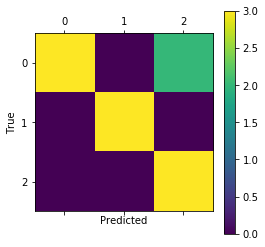

In [73]:
testnet.confusionmatrix()

## Dataset module network

In [74]:
imgloader.tfloaddata(shuffle = False)
traindata = imgloader.tfdict['train']
testdata = imgloader.tfdict['test']

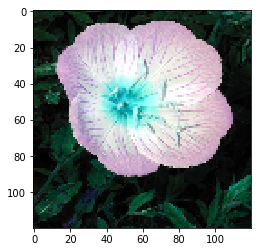

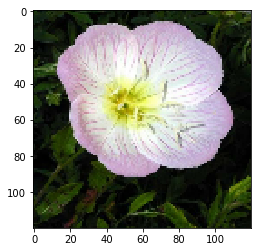

In [75]:
testiter = testdata.make_one_shot_iterator()
element = testiter.get_next()
testimg = tf.Session().run(element[0])[0]
    
img = cv2.imread(imgloader.pathdict['test'][0], 3)
res = cv2.resize(img, dsize=(120, 120), interpolation=cv2.INTER_CUBIC)
plot_image(res)
plot_image(testimg)

In [77]:
iterator = tf.data.Iterator.from_structure(traindata.output_types, traindata.output_shapes)
item = iterator.get_next()

train_init_op = iterator.make_initializer(traindata)
test_init_op = iterator.make_initializer(testdata)

with tf.Session() as sess:
    for _ in range(2):
        sess.run(train_init_op)
        for _ in range(5):
            img, lbl = sess.run(item)
            print("training label: ", lbl)

        sess.run(test_init_op)
        for _ in range(3):
            img, lbl = sess.run(item)
            print("testing label: ", lbl)

training label:  [0]
training label:  [0]
training label:  [0]
training label:  [0]
training label:  [0]
testing label:  [0]
testing label:  [0]
testing label:  [0]
training label:  [0]
training label:  [0]
training label:  [0]
training label:  [0]
training label:  [0]
testing label:  [0]
testing label:  [0]
testing label:  [0]


In [10]:
# # Image Parameters
# N_CLASSES = 102 # CHANGE HERE, total number of classes
# IMG_HEIGHT = 64 # CHANGE HERE, the image height to be resized to
# IMG_WIDTH = 64 # CHANGE HERE, the image width to be resized to
# CHANNELS = 3 # The 3 color channels, change to 1 if grayscale


# # Reading the dataset
# # 2 modes: 'file' or 'folder'
# def read_images(dataset_path, batch_size):
#     imagepaths, labels = list(), list()

#     # An ID will be affected to each sub-folders by alphabetical order
#     label = 0
#     # List the directory
#     classes = sorted(os.walk(dataset_path).__next__()[1])
#     # List each sub-directory (the classes)
#     for c in classes:
#         c_dir = os.path.join(dataset_path, c)
#         walk = os.walk(c_dir).__next__()
#         # Add each image to the training set
#         for sample in walk[2]:
#             # Only keeps jpeg images
#             if sample.endswith('.jpg') or sample.endswith('.jpeg'):
#                 imagepaths.append(os.path.join(c_dir, sample))
#                 labels.append(label)
#         label += 1

#     # Convert to Tensor
#     imagepaths = tf.convert_to_tensor(imagepaths, dtype=tf.string)
#     labels = tf.convert_to_tensor(labels, dtype=tf.int32)
#     # Build a TF Queue, shuffle data
#     image, label = tf.train.slice_input_producer([imagepaths, labels],
#                                                  shuffle=True)
    

#     # Read images from disk
#     image = tf.read_file(image)
#     image = tf.image.decode_jpeg(image, channels=CHANNELS)

#     # Resize images to a common size
#     image = tf.image.resize_images(image, [IMG_HEIGHT, IMG_WIDTH])

#     # Normalize
#     image = image * 1.0/127.5 - 1.0

#     # Create batches
#     X, Y = tf.train.batch([image, label], batch_size=batch_size,
#                           capacity=batch_size * 8,
#                           num_threads=4)

#     return X, Y

# # Build the data input
# datadir = './data/train' # the dataset file or root folder path.
# batchsize = 1
# X, Y = read_images(datadir, batchsize)
# X
# Y

In [ ]:
# # Parameters
# learning_rate = 0.001
# num_steps = 10000
# display_step = 100
# dropout = 0.75

# # Create model
# def conv_net(x, n_classes, dropout, reuse, is_training):
#     # Define a scope for reusing the variables
#     with tf.variable_scope('ConvNet', reuse=reuse):

#         # Convolution Layer with 32 filters and a kernel size of 5
#         conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
#         # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
#         conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

#         # Convolution Layer with 32 filters and a kernel size of 5
#         conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
#         # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
#         conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

#         # Flatten the data to a 1-D vector for the fully connected layer
#         fc1 = tf.contrib.layers.flatten(conv2)

#         # Fully connected layer (in contrib folder for now)
#         fc1 = tf.layers.dense(fc1, 1024)
#         # Apply Dropout (if is_training is False, dropout is not applied)
#         fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

#         # Output layer, class prediction
#         out = tf.layers.dense(fc1, n_classes)
#         # Because 'softmax_cross_entropy_with_logits' already apply softmax,
#         # we only apply softmax to testing network
#         out = tf.nn.softmax(out) if not is_training else out

#     return out

In [11]:


# # Because Dropout have different behavior at training and prediction time, we
# # need to create 2 distinct computation graphs that share the same weights.

# # Create a graph for training
# logits_train = conv_net(X, N_CLASSES, dropout, reuse=False, is_training=True)
# # Create another graph for testing that reuse the same weights
# logits_test = conv_net(X, N_CLASSES, dropout, reuse=True, is_training=False)

# # Define loss and optimizer (with train logits, for dropout to take effect)
# loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
#     logits=logits_train, labels=Y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# train_op = optimizer.minimize(loss_op)

# # Evaluate model (with test logits, for dropout to be disabled)
# correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.cast(Y, tf.int64))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# # Initialize the variables (i.e. assign their default value)
# init = tf.global_variables_initializer()

# # Saver object
# saver = tf.train.Saver()

# # Start training
# with tf.Session() as sess:

#     # Run the initializer
#     sess.run(init)

#     # Start the data queue
#     tf.train.start_queue_runners()

#     # Training cycle
#     for step in range(1, num_steps+1):

#         if step % display_step == 0:
#             # Run optimization and calculate batch loss and accuracy
#             _, loss, acc = sess.run([train_op, loss_op, accuracy])
#             print('Step ' + str(step) + ', Minibatch Loss= ' + \
#                   '{:.4f}'.format(loss) + ', Training Accuracy= ' + \
#                   '{:.3f}'.format(acc))
#         else:
#             # Only run the optimization op (backprop)
#             sess.run(train_op)

#     print('Optimization Finished!')

#     # Save your model
#     saver.save(sess, 'my_tf_model')